In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Input, Concatenate
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,BatchNormalization,Activation,Conv2D
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 建立資料集

In [2]:
batch_size=32
img_shape=(224,224)
input_shape=(224,224,3)

train_data_dir = '/kaggle/input/traindataset/train'
test_data_dir = '/kaggle/input/testdataset/test/test'


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.2 , 
    height_shift_range=0.2 ,
    shear_range=0.2 ,
    zoom_range=0.2,  
    horizontal_flip=True,  
    vertical_flip=True  
)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_shape,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',  
)
val_generator=train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
)
labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels),y=labels)
class_weights_dict = dict(enumerate(class_weights))

Found 22343 images belonging to 50 classes.
Found 5560 images belonging to 50 classes.
Found 7002 images belonging to 50 classes.


# 建立模型

In [3]:
base_model = tf.keras.applications.EfficientNetV2L(
    include_top = False,
    weights = 'imagenet',
    input_shape=input_shape,
    include_preprocessing=False
)
for layer in base_model.layers[:-30]:
    layer.trainable = False
x=base_model.output
x=GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x = Dense(512, activation='relu')(x) 
output_layer=Dense(50,activation='softmax')(x)


model = tf.keras.Model(inputs = base_model.input, outputs = output_layer)
#model.summary()

473176280/473176280 [==============================] - 2s 0us/step


In [4]:
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import math

@tf.function
def lr_scheduler(epoch, lr):
    if epoch % 8 == 0 and epoch != 0:
        lr = lr * 0.1
    if lr<1e-7:
        lr=1e-7
    return lr


In [5]:
my_callbacks=[
    tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            verbose=2,
            mode='auto'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=5,
            verbose=2,
            min_lr=1e-7,
            mode='auto'
    ),
    tf.keras.callbacks.ModelCheckpoint(
            filepath="/kaggle/working/EfficientV2L.h5",
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_freq='epoch'
    ),
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
]

In [6]:
model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(k=5,name='top_5_categorical_accuracy',dtype=None)])

In [7]:
epochs=30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/30


2024-01-09 01:06:21.849620: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 88/699 [==>...........................] - ETA: 4:53 - loss: 3.2471 - accuracy: 0.2077 - top_5_categorical_accuracy: 0.4553

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


699/699 [==============================] - ETA: 0s - loss: 1.6436 - accuracy: 0.5355 - top_5_categorical_accuracy: 0.8327

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


699/699 [==============================] - 487s 641ms/step - loss: 1.6436 - accuracy: 0.5355 - top_5_categorical_accuracy: 0.8327 - val_loss: 0.8701 - val_accuracy: 0.7090 - val_top_5_categorical_accuracy: 0.9608 - lr: 1.0000e-04
Epoch 2/30
699/699 [==============================] - 377s 539ms/step - loss: 0.9792 - accuracy: 0.6939 - top_5_categorical_accuracy: 0.9493 - val_loss: 0.7637 - val_accuracy: 0.7486 - val_top_5_categorical_accuracy: 0.9694 - lr: 1.0000e-04
Epoch 3/30
699/699 [==============================] - 377s 539ms/step - loss: 0.8350 - accuracy: 0.7323 - top_5_categorical_accuracy: 0.9646 - val_loss: 0.6849 - val_accuracy: 0.7692 - val_top_5_categorical_accuracy: 0.9737 - lr: 1.0000e-04
Epoch 4/30
699/699 [==============================] - 375s 536ms/step - loss: 0.7683 - accuracy: 0.7536 - top_5_categorical_accuracy: 0.9708 - val_loss: 0.6837 - val_accuracy: 0.7642 - val_top_5_categorical_accuracy: 0.9757 - lr: 1.0000e-04
Epoch 5/30
699/699 [===========================

# 畫出accuracy 以及loss curve

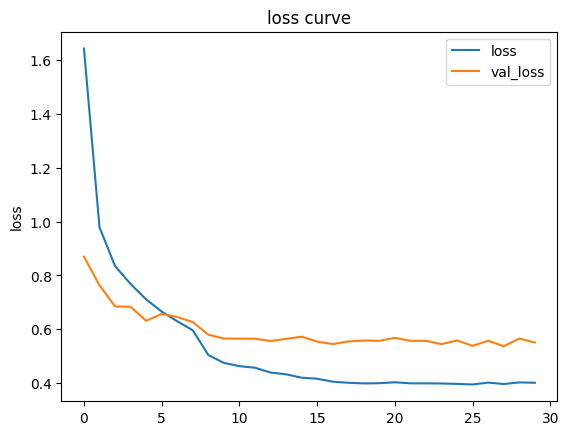

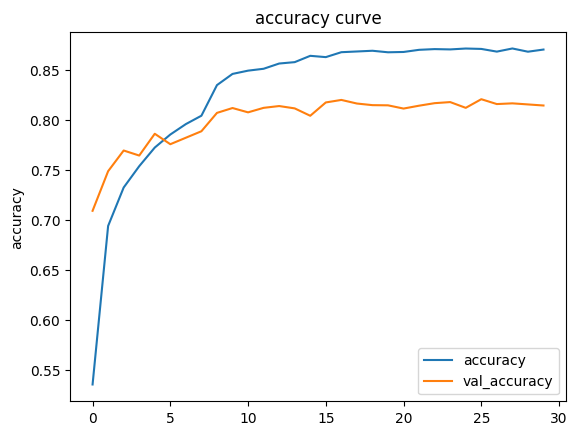

In [8]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Classification report 和Confusion matrix

219/219 [==============================] - 69s 288ms/step


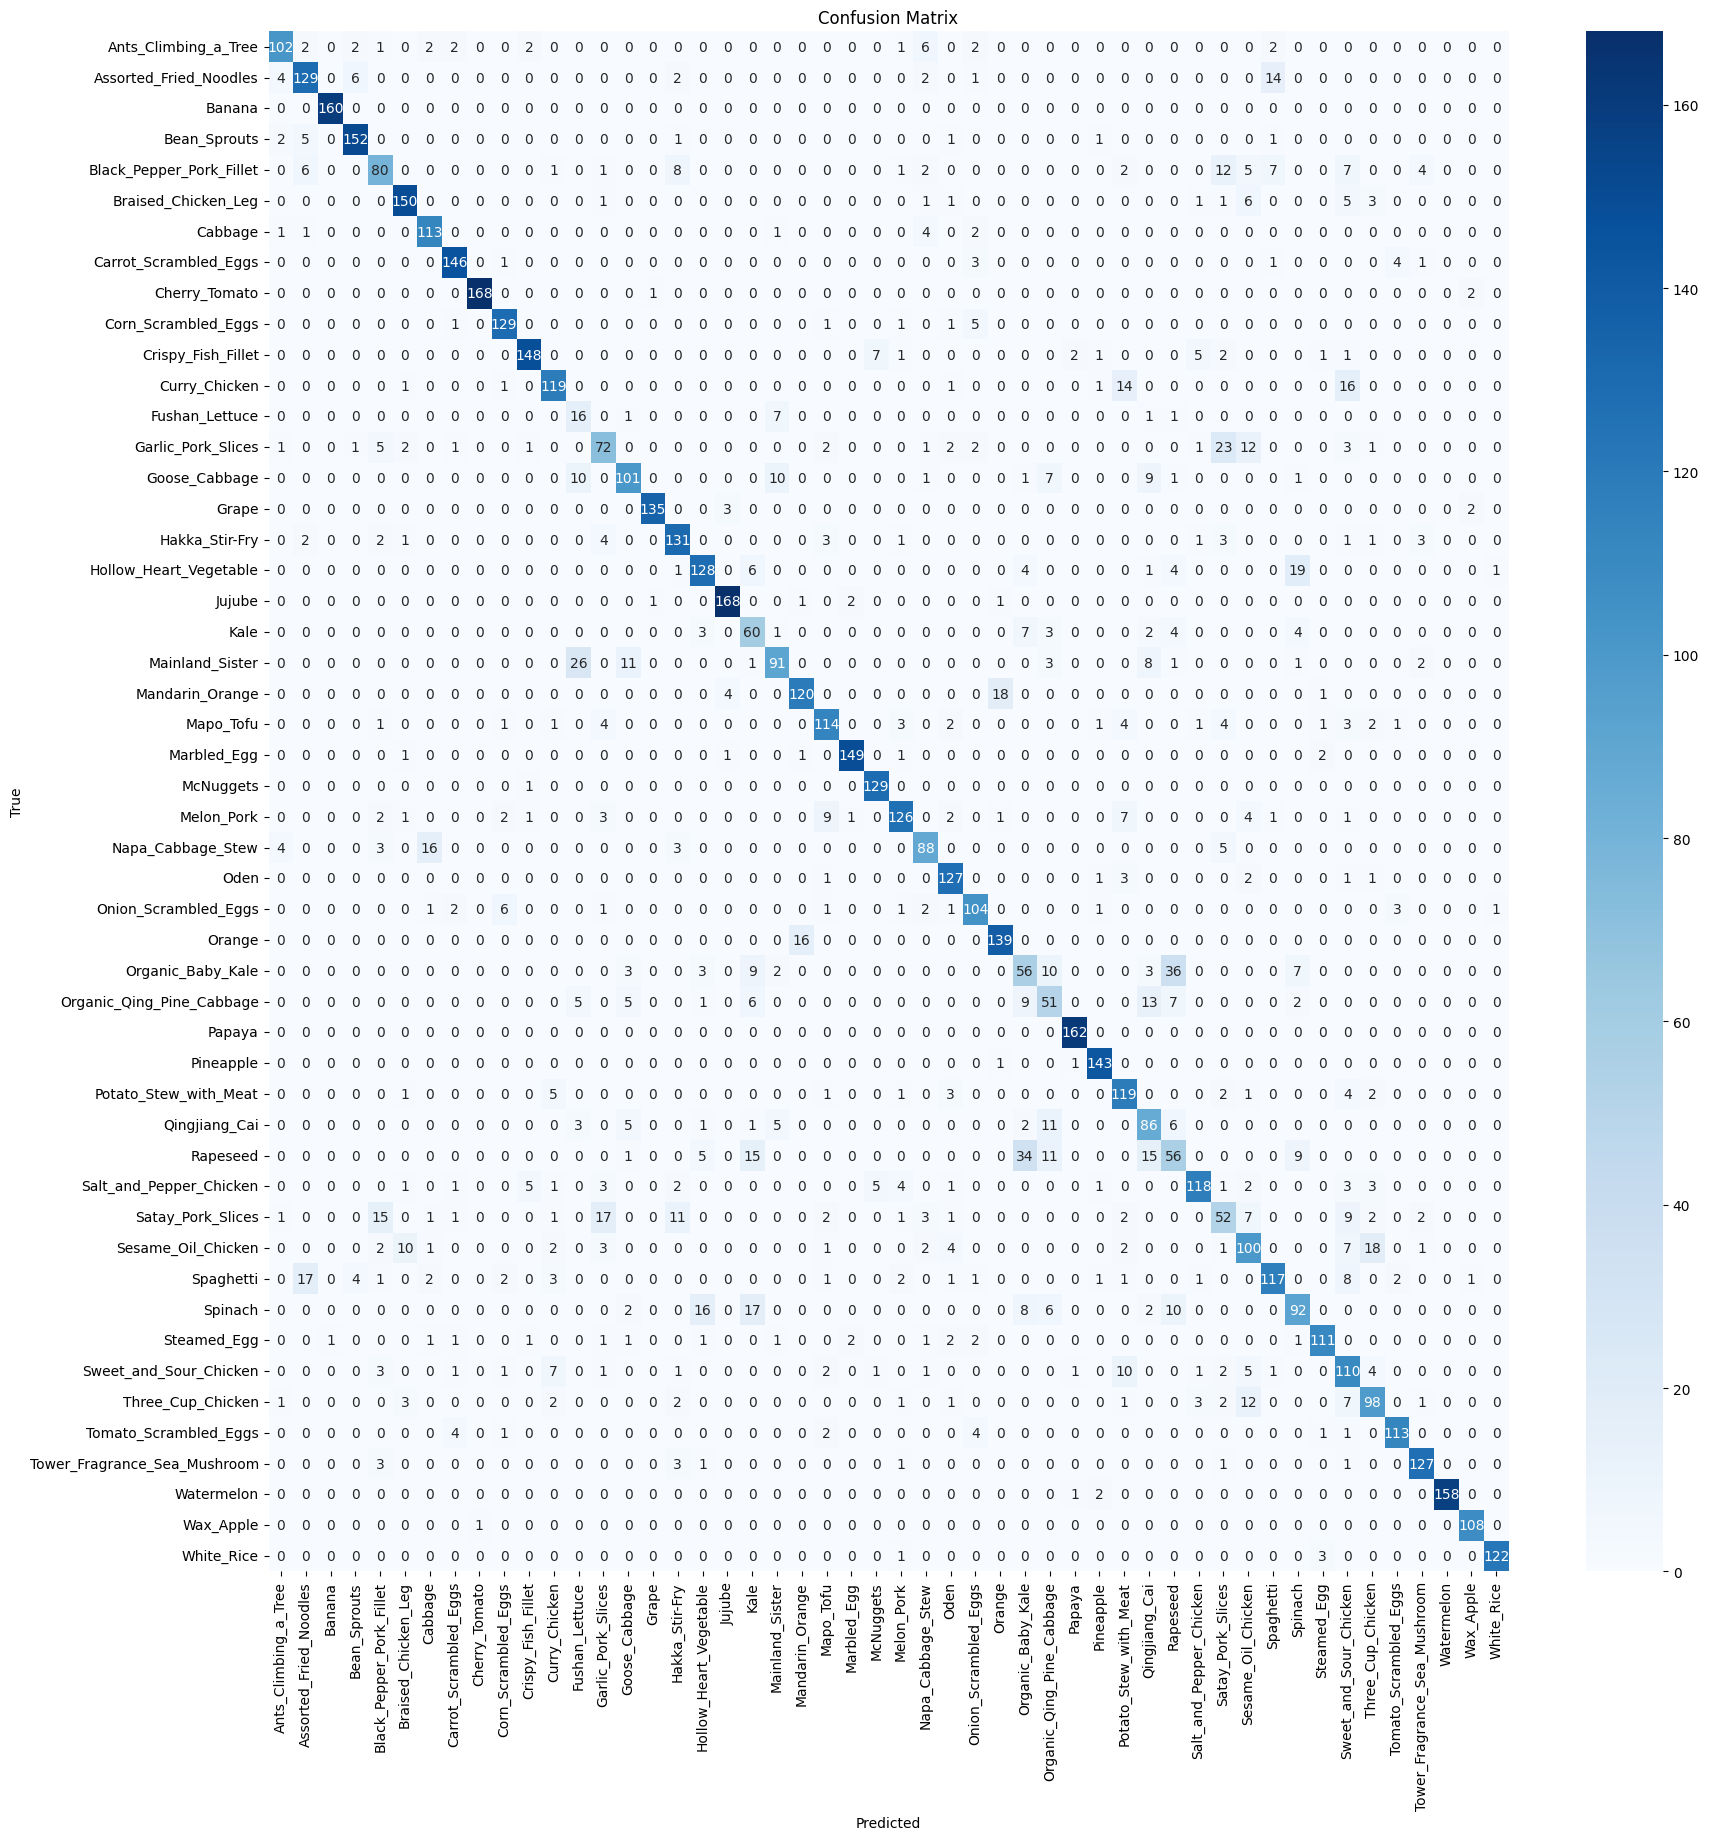

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical
class_indices = train_generator.class_indices


test_predictions = model.predict(test_generator)

predicted_labels = np.argmax(test_predictions, axis=1)
predicted_class_names = [list(class_indices.keys())[i] for i in predicted_labels]
true_labels=test_generator.classes
true_class_names = [list(class_indices.keys())[i] for i in true_labels]

cm = confusion_matrix(true_class_names, predicted_class_names)


plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",  
            xticklabels=list(class_indices.keys()), 
            yticklabels=list(class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [10]:
report = classification_report(predicted_class_names, true_class_names)
print(report)

                              precision    recall  f1-score   support

        Ants_Climbing_a_Tree       0.82      0.88      0.85       116
      Assorted_Fried_Noodles       0.82      0.80      0.81       162
                      Banana       1.00      0.99      1.00       161
                Bean_Sprouts       0.93      0.92      0.93       165
    Black_Pepper_Pork_Fillet       0.59      0.68      0.63       118
         Braised_Chicken_Leg       0.89      0.88      0.88       171
                     Cabbage       0.93      0.82      0.87       137
       Carrot_Scrambled_Eggs       0.94      0.91      0.92       160
               Cherry_Tomato       0.98      0.99      0.99       169
         Corn_Scrambled_Eggs       0.93      0.90      0.91       144
          Crispy_Fish_Fillet       0.88      0.93      0.91       159
               Curry_Chicken       0.78      0.84      0.81       142
              Fushan_Lettuce       0.62      0.27      0.37        60
          Garlic_Po

# 畫出Top 5 Accuracy curve

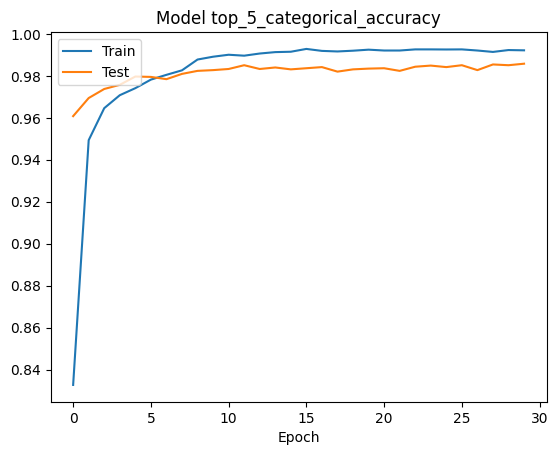

In [11]:
plt.plot(history.history['top_5_categorical_accuracy'])
plt.plot(history.history['val_top_5_categorical_accuracy'])
plt.title('Model top_5_categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'],loc='upper left')
plt.show()